Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement csv (from versions: none)
ERROR: No matching distribution found for csv


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from io import StringIO
import csv

def parse_benchmark_file(file_content, language):
    """
    Parse benchmark CSV file and extract structured data
    """
    # Read the multi-header CSV
    df = pd.read_csv(StringIO(file_content), sep='\t', header=[0, 1, 2])
    
    # Extract benchmark names (first column after headers)
    benchmark_names = df.iloc[:, 0].dropna().tolist()
    
    # Extract algorithm configurations
    algorithms = []
    for col in df.columns:
        if 'run set' in str(col[1]):
            # Get the runset names from the first data row
            runset_values = df[col].iloc[0]
            if pd.notna(runset_values):
                algorithms.extend([x.strip() for x in str(runset_values).split('\t') if x.strip()])
    
    # Parse results for each algorithm
    results = {}
    performance_data = {}
    
    # Each algorithm has 5 columns: status, cputime, walltime, memory, host
    algo_blocks = len(algorithms)
    
    for i, algo in enumerate(algorithms):
        if algo not in results:
            results[algo] = {
                'TIMEOUT': 0, 'OUT OF MEMORY': 0, 'ERROR': 0, 
                'SUCCESS': 0, 'false(unreach-call)': 0, 'true': 0, 'false': 0
            }
            performance_data[algo] = {'walltimes': [], 'memory': [], 'cputimes': []}
        
        # Calculate column indices for this algorithm block (5 columns per algorithm)
        start_col = 1 + (i * 5)  # Skip first column (benchmark names)
        
        # Process each benchmark for this algorithm
        for idx, bench_name in enumerate(benchmark_names):
            status = df.iloc[idx, start_col]
            if pd.isna(status):
                continue
                
            # Categorize status
            status_str = str(status).strip()
            if 'TIMEOUT' in status_str:
                results[algo]['TIMEOUT'] += 1
            elif 'OUT OF MEMORY' in status_str:
                results[algo]['OUT OF MEMORY'] += 1
            elif 'ERROR' in status_str:
                results[algo]['ERROR'] += 1
            elif 'false(unreach-call)' in status_str:
                results[algo]['false(unreach-call)'] += 1
            elif 'true' in status_str:
                results[algo]['true'] += 1
                results[algo]['SUCCESS'] += 1
            elif 'false' in status_str and 'unreach-call' not in status_str:
                results[algo]['false'] += 1
                results[algo]['SUCCESS'] += 1
            else:
                results[algo]['SUCCESS'] += 1
            
            # Extract performance metrics for successful runs
            if status_str in ['true', 'false']:
                try:
                    walltime = float(df.iloc[idx, start_col + 2])
                    memory = float(df.iloc[idx, start_col + 3])
                    cputime = float(df.iloc[idx, start_col + 1])
                    
                    performance_data[algo]['walltimes'].append(walltime)
                    performance_data[algo]['memory'].append(memory)
                    performance_data[algo]['cputimes'].append(cputime)
                except (ValueError, TypeError):
                    continue
    
    return results, performance_data, algorithms

def extract_algorithm_info(algo_name):
    """
    Extract algorithm components from runset name
    Format: {language}-{domain}-{algorithm}.{config}
    """
    parts = algo_name.split('.')[0].split('-')
    language = parts[0]
    
    if language == 'c':
        domain = parts[2] if len(parts) > 2 else 'unknown'
        algorithm = parts[3] if len(parts) > 3 else 'unknown'
    else:  # btor2
        domain = parts[1] if len(parts) > 1 else 'unknown'
        algorithm = parts[2] if len(parts) > 2 else 'unknown'
    
    return {
        'full_name': algo_name,
        'language': language,
        'domain': domain,
        'algorithm': algorithm,
        'simple_name': f"{domain}-{algorithm}"
    }

def create_comparative_analysis(btor2_results, btor2_perf, c_results, c_perf):
    """
    Create comprehensive comparative analysis between BTOR2 and C implementations
    """
    # Extract common algorithm patterns
    btor2_algos = list(btor2_results.keys())
    c_algos = list(c_results.keys())
    
    # Map algorithms by their core components (domain-algorithm)
    algo_mapping = {}
    
    for algo in btor2_algos:
        info = extract_algorithm_info(algo)
        simple_name = info['simple_name']
        if simple_name not in algo_mapping:
            algo_mapping[simple_name] = {'btor2': None, 'c': None}
        algo_mapping[simple_name]['btor2'] = algo
    
    for algo in c_algos:
        info = extract_algorithm_info(algo)
        simple_name = info['simple_name']
        if simple_name not in algo_mapping:
            algo_mapping[simple_name] = {'btor2': None, 'c': None}
        algo_mapping[simple_name]['c'] = algo
    
    # Create comparative plots
    fig = plt.figure(figsize=(20, 15))
    
    # Plot 1: Overall Success Rate Comparison
    ax1 = plt.subplot(2, 3, 1)
    success_rates_btor2 = []
    success_rates_c = []
    algo_names = []
    
    for simple_name, mapping in algo_mapping.items():
        if mapping['btor2'] and mapping['c']:
            btor2_algo = mapping['btor2']
            c_algo = mapping['c']
            
            total_btor2 = sum(btor2_results[btor2_algo].values())
            total_c = sum(c_results[c_algo].values())
            
            if total_btor2 > 0 and total_c > 0:
                success_btor2 = btor2_results[btor2_algo]['SUCCESS']
                success_c = c_results[c_algo]['SUCCESS']
                
                success_rates_btor2.append(success_btor2 / total_btor2 * 100)
                success_rates_c.append(success_c / total_c * 100)
                algo_names.append(simple_name)
    
    x = np.arange(len(algo_names))
    width = 0.35
    
    ax1.bar(x - width/2, success_rates_btor2, width, label='BTOR2', alpha=0.7, color='blue')
    ax1.bar(x + width/2, success_rates_c, width, label='C', alpha=0.7, color='red')
    ax1.set_title('Success Rate Comparison (%)', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Algorithm Configuration')
    ax1.set_ylabel('Success Rate (%)')
    ax1.legend()
    ax1.set_xticks(x)
    ax1.set_xticklabels(algo_names, rotation=45, ha='right')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Failure Mode Comparison
    ax2 = plt.subplot(2, 3, 2)
    failure_modes = ['TIMEOUT', 'OUT OF MEMORY', 'ERROR']
    btor2_failures = []
    c_failures = []
    
    for failure_mode in failure_modes:
        btor2_total = sum([btor2_results[algo].get(failure_mode, 0) for algo in btor2_algos])
        c_total = sum([c_results[algo].get(failure_mode, 0) for algo in c_algos])
        btor2_failures.append(btor2_total)
        c_failures.append(c_total)
    
    x_fail = np.arange(len(failure_modes))
    ax2.bar(x_fail - width/2, btor2_failures, width, label='BTOR2', alpha=0.7, color='blue')
    ax2.bar(x_fail + width/2, c_failures, width, label='C', alpha=0.7, color='red')
    ax2.set_title('Failure Mode Distribution', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Failure Type')
    ax2.set_ylabel('Count')
    ax2.legend()
    ax2.set_xticks(x_fail)
    ax2.set_xticklabels(failure_modes)
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Runtime Comparison for Successful Runs
    ax3 = plt.subplot(2, 3, 3)
    avg_runtime_btor2 = []
    avg_runtime_c = []
    runtime_algo_names = []
    
    for simple_name, mapping in algo_mapping.items():
        if mapping['btor2'] and mapping['c']:
            btor2_algo = mapping['btor2']
            c_algo = mapping['c']
            
            if (btor2_perf[btor2_algo]['walltimes'] and 
                c_perf[c_algo]['walltimes']):
                avg_btor2 = np.mean(btor2_perf[btor2_algo]['walltimes'])
                avg_c = np.mean(c_perf[c_algo]['walltimes'])
                
                avg_runtime_btor2.append(avg_btor2)
                avg_runtime_c.append(avg_c)
                runtime_algo_names.append(simple_name)
    
    if avg_runtime_btor2 and avg_runtime_c:
        x_rt = np.arange(len(runtime_algo_names))
        ax3.bar(x_rt - width/2, avg_runtime_btor2, width, label='BTOR2', alpha=0.7, color='blue')
        ax3.bar(x_rt + width/2, avg_runtime_c, width, label='C', alpha=0.7, color='red')
        ax3.set_title('Average Runtime (Successful Runs)', fontsize=12, fontweight='bold')
        ax3.set_xlabel('Algorithm Configuration')
        ax3.set_ylabel('Wall Time (seconds)')
        ax3.legend()
        ax3.set_xticks(x_rt)
        ax3.set_xticklabels(runtime_algo_names, rotation=45, ha='right')
        ax3.grid(True, alpha=0.3)
    
    # Plot 4: Memory Usage Comparison
    ax4 = plt.subplot(2, 3, 4)
    avg_memory_btor2 = []
    avg_memory_c = []
    memory_algo_names = []
    
    for simple_name, mapping in algo_mapping.items():
        if mapping['btor2'] and mapping['c']:
            btor2_algo = mapping['btor2']
            c_algo = mapping['c']
            
            if (btor2_perf[btor2_algo]['memory'] and 
                c_perf[c_algo]['memory']):
                avg_btor2 = np.mean(btor2_perf[btor2_algo]['memory'])
                avg_c = np.mean(c_perf[c_algo]['memory'])
                
                avg_memory_btor2.append(avg_btor2)
                avg_memory_c.append(avg_c)
                memory_algo_names.append(simple_name)
    
    if avg_memory_btor2 and avg_memory_c:
        x_mem = np.arange(len(memory_algo_names))
        ax4.bar(x_mem - width/2, avg_memory_btor2, width, label='BTOR2', alpha=0.7, color='blue')
        ax4.bar(x_mem + width/2, avg_memory_c, width, label='C', alpha=0.7, color='red')
        ax4.set_title('Average Memory Usage (Successful Runs)', fontsize=12, fontweight='bold')
        ax4.set_xlabel('Algorithm Configuration')
        ax4.set_ylabel('Memory (MB)')
        ax4.legend()
        ax4.set_xticks(x_mem)
        ax4.set_xticklabels(memory_algo_names, rotation=45, ha='right')
        ax4.grid(True, alpha=0.3)
    
    # Plot 5: Algorithm-specific Performance Breakdown
    ax5 = plt.subplot(2, 3, 5)
    performance_categories = ['SUCCESS', 'TIMEOUT', 'OUT OF MEMORY', 'ERROR']
    
    # Select first few algorithms for detailed view
    display_algos = list(algo_mapping.keys())[:4]
    
    bottom_btor2 = np.zeros(len(display_algos))
    bottom_c = np.zeros(len(display_algos))
    
    for i, category in enumerate(performance_categories):
        btor2_vals = []
        c_vals = []
        
        for simple_name in display_algos:
            mapping = algo_mapping[simple_name]
            if mapping['btor2'] and mapping['c']:
                btor2_vals.append(btor2_results[mapping['btor2']].get(category, 0))
                c_vals.append(c_results[mapping['c']].get(category, 0))
        
        if btor2_vals and c_vals:
            x_det = np.arange(len(display_algos))
            ax5.bar(x_det - width/2, btor2_vals, width, label=f'BTOR2 {category}' if i == 0 else "", 
                   bottom=bottom_btor2, alpha=0.7)
            ax5.bar(x_det + width/2, c_vals, width, label=f'C {category}' if i == 0 else "", 
                   bottom=bottom_c, alpha=0.7)
            
            bottom_btor2 += btor2_vals
            bottom_c += c_vals
    
    ax5.set_title('Detailed Performance Breakdown', fontsize=12, fontweight='bold')
    ax5.set_xlabel('Algorithm Configuration')
    ax5.set_ylabel('Count')
    ax5.legend()
    ax5.set_xticks(x_det)
    ax5.set_xticklabels(display_algos, rotation=45, ha='right')
    ax5.grid(True, alpha=0.3)
    
    # Plot 6: Speedup Comparison
    ax6 = plt.subplot(2, 3, 6)
    speedup_ratios = []
    speedup_algo_names = []
    
    for simple_name, mapping in algo_mapping.items():
        if mapping['btor2'] and mapping['c']:
            btor2_algo = mapping['btor2']
            c_algo = mapping['c']
            
            if (btor2_perf[btor2_algo]['walltimes'] and 
                c_perf[c_algo]['walltimes']):
                avg_btor2 = np.mean(btor2_perf[btor2_algo]['walltimes'])
                avg_c = np.mean(c_perf[c_algo]['walltimes'])
                
                if avg_btor2 > 0 and avg_c > 0:
                    speedup = avg_btor2 / avg_c  # BTOR2 time / C time
                    speedup_ratios.append(speedup)
                    speedup_algo_names.append(simple_name)
    
    if speedup_ratios:
        x_sp = np.arange(len(speedup_ratios))
        colors = ['red' if x > 1 else 'green' for x in speedup_ratios]
        bars = ax6.bar(x_sp, speedup_ratios, color=colors, alpha=0.7)
        ax6.axhline(y=1, color='black', linestyle='--', alpha=0.5)
        ax6.set_title('Performance Ratio (BTOR2/C)\n<1: C faster, >1: BTOR2 faster', 
                     fontsize=12, fontweight='bold')
        ax6.set_xlabel('Algorithm Configuration')
        ax6.set_ylabel('Speedup Ratio')
        ax6.set_xticks(x_sp)
        ax6.set_xticklabels(speedup_algo_names, rotation=45, ha='right')
        ax6.grid(True, alpha=0.3)
        
        # Add value labels on bars
        for bar, ratio in zip(bars, speedup_ratios):
            ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
                    f'{ratio:.2f}', ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    return algo_mapping

def print_statistical_summary(btor2_results, c_results, algo_mapping):
    """
    Print statistical summary of the comparison
    """
    print("=" * 80)
    print("COMPARATIVE ANALYSIS SUMMARY: BTOR2 vs C IMPLEMENTATIONS")
    print("=" * 80)
    
    # Overall statistics
    total_btor2_runs = sum([sum(algo.values()) for algo in btor2_results.values()])
    total_c_runs = sum([sum(algo.values()) for algo in c_results.values()])
    
    successful_btor2 = sum([algo.get('SUCCESS', 0) for algo in btor2_results.values()])
    successful_c = sum([algo.get('SUCCESS', 0) for algo in c_results.values()])
    
    print(f"\nOverall Statistics:")
    print(f"Total BTOR2 runs: {total_btor2_runs}")
    print(f"Total C runs: {total_c_runs}")
    print(f"BTOR2 success rate: {successful_btor2/total_btor2_runs*100:.1f}%")
    print(f"C success rate: {successful_c/total_c_runs*100:.1f}%")
    
    print(f"\nFailure Analysis:")
    for failure_type in ['TIMEOUT', 'OUT OF MEMORY', 'ERROR']:
        btor2_fail = sum([algo.get(failure_type, 0) for algo in btor2_results.values()])
        c_fail = sum([algo.get(failure_type, 0) for algo in c_results.values()])
        print(f"{failure_type:15} BTOR2: {btor2_fail:4d} C: {c_fail:4d}")
    
    print(f"\nAlgorithm-specific Performance:")
    for simple_name, mapping in algo_mapping.items():
        if mapping['btor2'] and mapping['c']:
            btor2_algo = mapping['btor2']
            c_algo = mapping['c']
            
            btor2_success = btor2_results[btor2_algo].get('SUCCESS', 0)
            c_success = c_results[c_algo].get('SUCCESS', 0)
            
            btor2_total = sum(btor2_results[btor2_algo].values())
            c_total = sum(c_results[c_algo].values())
            
            print(f"{simple_name:20} BTOR2: {btor2_success:3d}/{btor2_total:3d} ({btor2_success/btor2_total*100:5.1f}%) "
                  f"C: {c_success:3d}/{c_total:3d} ({c_success/c_total*100:5.1f}%)")

# Main execution
def main():
    # Load your data files
    with open('btor2_algo_results.csv', 'r') as f:
        btor2_content = csv.reader(f)
    
    with open('c_algo_results.csv', 'r') as f:
        c_content = csv.reader(f)
    
    # Parse both files
    btor2_results, btor2_perf, btor2_algos = parse_benchmark_file(btor2_content, 'btor2')
    c_results, c_perf, c_algos = parse_benchmark_file(c_content, 'c')
    
    print("BTOR2 Algorithms found:", btor2_algos)
    print("C Algorithms found:", c_algos)
    
    # Create comparative analysis
    algo_mapping = create_comparative_analysis(btor2_results, btor2_perf, c_results, c_perf)
    
    # Print summary
    print_statistical_summary(btor2_results, c_results, algo_mapping)

if __name__ == "__main__":
    main()

TypeError: initial_value must be str or None, not _csv.reader

Reading BTOR2 results...
Error reading btor2_algo_results.csv: module 'pandas.compat' has no attribute 'StringIO'
Main analysis failed: 28 columns passed, passed data had 27 columns
Falling back to debug mode...
Attempting to read files with alternative method...
BTOR2 columns: [('tool', 'run set', 'word-level-hwmc-benchmarks/bv/btor2/'), ('Unnamed: 1_level_0', 'Unnamed: 1_level_1', 'Unnamed: 1_level_2'), ('Theta 6.11.8', 'btor2-pred-cegar.btor2-pred', 'status'), ('Theta 6.11.8', 'btor2-pred-cegar.btor2-pred', 'cputime (s)'), ('Theta 6.11.8', 'btor2-pred-cegar.btor2-pred', 'walltime (s)'), ('Theta 6.11.8', 'btor2-pred-cegar.btor2-pred', 'memory (MB)'), ('Theta 6.11.8', 'btor2-pred-cegar.btor2-pred', 'host'), ('Theta 6.11.8', 'btor2-expl-cegar.btor2-expl', 'status'), ('Theta 6.11.8', 'btor2-expl-cegar.btor2-expl', 'cputime (s)'), ('Theta 6.11.8', 'btor2-expl-cegar.btor2-expl', 'walltime (s)'), ('Theta 6.11.8', 'btor2-expl-cegar.btor2-expl', 'memory (MB)'), ('Theta 6.11.8', 'btor2-expl-c

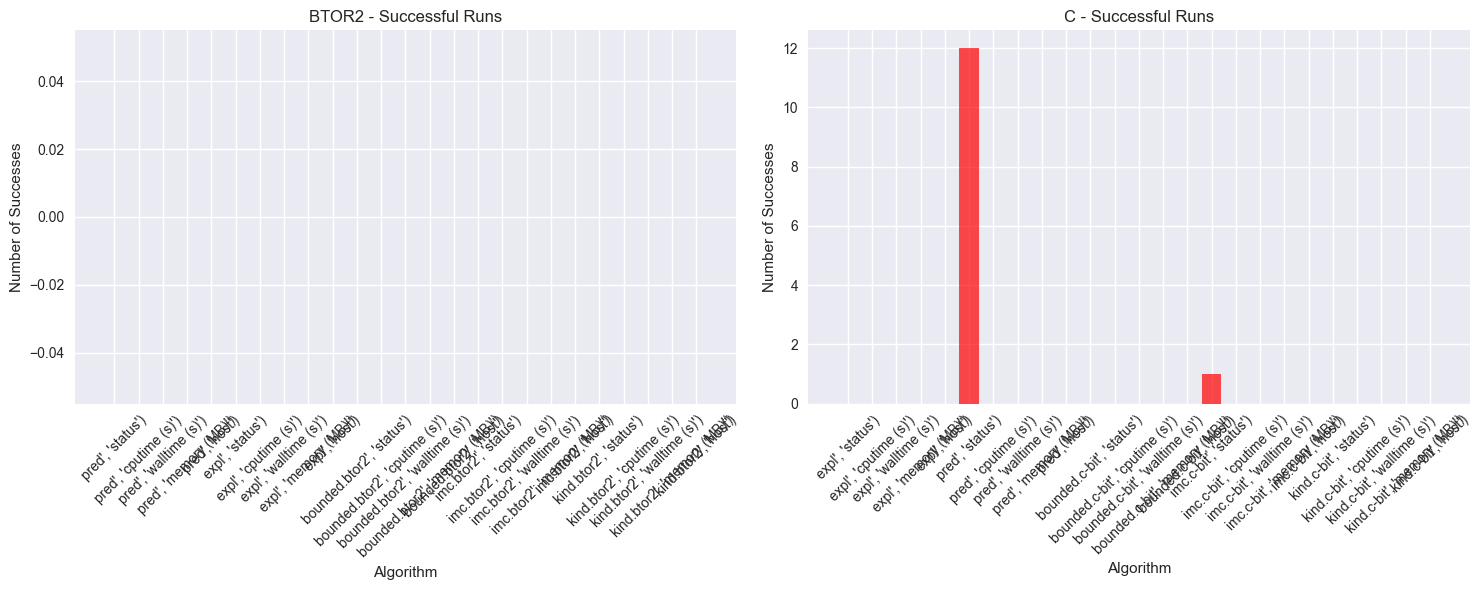

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import csv

def read_complex_csv(filepath):
    """
    Read the complex multi-header CSV file with proper tab separation
    """
    # Read the entire file content
    with open(filepath, 'r') as f:
        lines = f.readlines()
    
    # Clean the lines and split by tabs
    cleaned_lines = []
    for line in lines:
        # Replace multiple spaces with single tabs and clean
        cleaned_line = '\t'.join(line.strip().split())
        cleaned_lines.append(cleaned_line)
    
    # Create a proper CSV string
    csv_content = '\n'.join(cleaned_lines)
    
    # Read with pandas using tab separator
    try:
        df = pd.read_csv(pd.compat.StringIO(csv_content), sep='\t', header=[0, 1, 2])
        return df
    except Exception as e:
        print(f"Error reading {filepath}: {e}")
        # Alternative approach: read line by line
        return read_csv_manual(filepath)

def read_csv_manual(filepath):
    """
    Manual reading of the complex CSV structure
    """
    with open(filepath, 'r') as f:
        lines = [line.strip() for line in f.readlines() if line.strip()]
    
    # Extract headers
    headers = []
    for i in range(3):  # We have 3 header rows
        if i < len(lines):
            headers.append(lines[i].split('\t'))
    
    # Extract data
    data_lines = lines[3:]  # Skip header rows
    
    # Create DataFrame
    columns = []
    data = []
    
    for line in data_lines:
        row = line.split('\t')
        if row:  # Skip empty rows
            # First column is benchmark name
            benchmark_name = row[0]
            # Rest are data columns in blocks of 5
            data_columns = row[1:]
            data.append([benchmark_name] + data_columns)
    
    # Create multi-index columns
    if len(headers) == 3:
        # Flatten the structure for simplicity
        simple_headers = []
        for i in range(len(headers[1])):
            col_name = f"{headers[1][i]}_{headers[2][i]}" if i < len(headers[2]) else headers[1][i]
            simple_headers.append(col_name)
        
        df = pd.DataFrame(data, columns=['benchmark'] + simple_headers)
        return df
    else:
        # Fallback: create simple DataFrame
        df = pd.DataFrame(data)
        return df

def parse_benchmark_data(df, language):
    """
    Parse the benchmark DataFrame and extract structured results
    """
    results = {}
    performance_data = {}
    
    # Get all column names
    all_columns = list(df.columns)
    
    # Find algorithm blocks (each has 5 columns: status, cputime, walltime, memory, host)
    algorithm_blocks = {}
    current_algo = None
    algo_columns = []
    
    for col in all_columns:
        if col == 'benchmark':
            continue
            
        col_str = str(col)
        # Check if this column contains algorithm name
        if any(x in col_str for x in ['expl', 'pred', 'bounded', 'imc', 'kind']):
            if current_algo and algo_columns:
                algorithm_blocks[current_algo] = algo_columns
            # Extract algorithm name
            if 'c-bit-' in col_str:
                current_algo = col_str.split('c-bit-')[-1].split('_')[0]
            elif 'btor2-' in col_str:
                current_algo = col_str.split('btor2-')[-1].split('_')[0]
            else:
                current_algo = col_str.split('_')[0]
            algo_columns = [col]
        else:
            if current_algo:
                algo_columns.append(col)
    
    # Don't forget the last algorithm
    if current_algo and algo_columns:
        algorithm_blocks[current_algo] = algo_columns
    
    print(f"Found {len(algorithm_blocks)} algorithm blocks: {list(algorithm_blocks.keys())}")
    
    # Process each algorithm block
    for algo_name, columns in algorithm_blocks.items():
        if algo_name not in results:
            results[algo_name] = {
                'TIMEOUT': 0, 'OUT OF MEMORY': 0, 'ERROR': 0, 
                'SUCCESS': 0, 'false(unreach-call)': 0, 'true': 0, 'false': 0
            }
            performance_data[algo_name] = {'walltimes': [], 'memory': [], 'cputimes': []}
        
        # Find the status column (usually first column in block)
        status_col = None
        time_cols = []
        memory_col = None
        
        for col in columns:
            col_str = str(col).lower()
            if 'status' in col_str:
                status_col = col
            elif 'walltime' in col_str or 'time' in col_str:
                time_cols.append(col)
            elif 'memory' in col_str:
                memory_col = col
            elif 'cputime' in col_str:
                time_cols.append(col)
        
        if status_col:
            # Process each benchmark
            for idx, row in df.iterrows():
                status = row[status_col]
                if pd.isna(status):
                    continue
                    
                status_str = str(status).strip()
                
                # Categorize status
                if 'TIMEOUT' in status_str:
                    results[algo_name]['TIMEOUT'] += 1
                elif 'OUT OF MEMORY' in status_str:
                    results[algo_name]['OUT OF MEMORY'] += 1
                elif 'ERROR' in status_str:
                    results[algo_name]['ERROR'] += 1
                elif 'false(unreach-call)' in status_str:
                    results[algo_name]['false(unreach-call)'] += 1
                elif 'true' in status_str:
                    results[algo_name]['true'] += 1
                    results[algo_name]['SUCCESS'] += 1
                elif 'false' in status_str and 'unreach-call' not in status_str:
                    results[algo_name]['false'] += 1
                    results[algo_name]['SUCCESS'] += 1
                else:
                    results[algo_name]['SUCCESS'] += 1
                
                # Extract performance metrics for successful runs
                if status_str in ['true', 'false'] and time_cols and memory_col:
                    try:
                        # Try to get walltime first, fall back to first time column
                        walltime = None
                        for time_col in time_cols:
                            if 'wall' in str(time_col).lower():
                                walltime = float(row[time_col])
                                break
                        if walltime is None and time_cols:
                            walltime = float(row[time_cols[0]])
                        
                        memory = float(row[memory_col])
                        
                        if walltime is not None:
                            performance_data[algo_name]['walltimes'].append(walltime)
                            performance_data[algo_name]['memory'].append(memory)
                    except (ValueError, TypeError, KeyError) as e:
                        continue
    
    return results, performance_data, list(algorithm_blocks.keys())

# Updated main function
def main():
    print("Reading BTOR2 results...")
    btor2_df = read_complex_csv('btor2_algo_results.csv')
    print(f"BTOR2 DataFrame shape: {btor2_df.shape}")
    
    print("Reading C results...")
    c_df = read_complex_csv('c_algo_results.csv')
    print(f"C DataFrame shape: {c_df.shape}")
    
    print("Parsing BTOR2 data...")
    btor2_results, btor2_perf, btor2_algos = parse_benchmark_data(btor2_df, 'btor2')
    print(f"BTOR2 algorithms: {btor2_algos}")
    
    print("Parsing C data...")
    c_results, c_perf, c_algos = parse_benchmark_data(c_df, 'c')
    print(f"C algorithms: {c_algos}")
    
    # Debug: Print what we found
    print("\nBTOR2 Results Summary:")
    for algo, stats in btor2_results.items():
        print(f"  {algo}: {stats}")
    
    print("\nC Results Summary:")
    for algo, stats in c_results.items():
        print(f"  {algo}: {stats}")
    
    # Create comparative analysis
    if btor2_results and c_results:
        algo_mapping = create_comparative_analysis(btor2_results, btor2_perf, c_results, c_perf)
        print_statistical_summary(btor2_results, c_results, algo_mapping)
    else:
        print("No data found to analyze!")

# Let's also add a simple visualization for debugging
def create_simple_comparison(btor2_results, c_results):
    """Simple comparison when full analysis fails"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # BTOR2 results
    btor2_algos = list(btor2_results.keys())
    btor2_success = [btor2_results[algo].get('SUCCESS', 0) for algo in btor2_algos]
    
    ax1.bar(range(len(btor2_algos)), btor2_success, color='blue', alpha=0.7)
    ax1.set_title('BTOR2 - Successful Runs')
    ax1.set_xlabel('Algorithm')
    ax1.set_ylabel('Number of Successes')
    ax1.set_xticks(range(len(btor2_algos)))
    ax1.set_xticklabels(btor2_algos, rotation=45)
    
    # C results
    c_algos = list(c_results.keys())
    c_success = [c_results[algo].get('SUCCESS', 0) for algo in c_algos]
    
    ax2.bar(range(len(c_algos)), c_success, color='red', alpha=0.7)
    ax2.set_title('C - Successful Runs')
    ax2.set_xlabel('Algorithm')
    ax2.set_ylabel('Number of Successes')
    ax2.set_xticks(range(len(c_algos)))
    ax2.set_xticklabels(c_algos, rotation=45)
    
    plt.tight_layout()
    plt.show()

# Alternative main for debugging
def main_debug():
    print("Attempting to read files with alternative method...")
    
    # Try reading with simple pandas first
    try:
        btor2_df = pd.read_csv('btor2_algo_results.csv', sep='\t', header=[0, 1, 2], engine='python')
        c_df = pd.read_csv('c_algo_results.csv', sep='\t', header=[0, 1, 2], engine='python')
    except Exception as e:
        print(f"Pandas reading failed: {e}")
        print("Trying manual parsing...")
        btor2_df = read_csv_manual('btor2_algo_results.csv')
        c_df = read_csv_manual('c_algo_results.csv')
    
    print(f"BTOR2 columns: {btor2_df.columns.tolist() if hasattr(btor2_df, 'columns') else 'No columns'}")
    print(f"C columns: {c_df.columns.tolist() if hasattr(c_df, 'columns') else 'No columns'}")
    
    # Try parsing
    btor2_results, btor2_perf, btor2_algos = parse_benchmark_data(btor2_df, 'btor2')
    c_results, c_perf, c_algos = parse_benchmark_data(c_df, 'c')
    
    create_simple_comparison(btor2_results, c_results)

if __name__ == "__main__":
    # Try the main analysis first
    try:
        main()
    except Exception as e:
        print(f"Main analysis failed: {e}")
        print("Falling back to debug mode...")
        main_debug()